In [1]:
import pandas as pd

# Load CpGs inside MEs
cpgs = pd.read_csv('cpgs_within_metastable_epialleles.tsv', sep='\t')

# Load MEs
mes = pd.read_csv("metastable_epiallele_list.csv", sep=",", header=0)
mes = mes.drop(columns=["Hg19 data"])

# Create a function to assign ME ID for each CpG
def assign_me(row):
    for _, me in mes.iterrows():
        if (row['Chr'] == me['Chr']) and (row['Start'] >= me['Start']) and (row['End'] <= me['End']):
            return f"{me['Chr']}:{me['Start']}-{me['End']}"
    return None

# Apply function - WARNING: This can be slow for large datasets
cpgs['ME_ID'] = cpgs.apply(assign_me, axis=1)

# Drop CpGs not in any ME (if any)
cpgs = cpgs.dropna(subset=['ME_ID'])

cpgs = cpgs.drop_duplicates(subset=['Chr', 'Start', 'End', 'ME_ID'])

In [2]:
# Drop CpGs not in any ME (if any)
cpgs = cpgs.dropna(subset=['ME_ID'])

cpgs = cpgs.drop_duplicates(subset=['Chr', 'Start', 'End', 'ME_ID'])

In [3]:
# Drop columns ending in '_cov'
cov_cols = [col for col in cpgs.columns if col.endswith('_cov')]
cpgs = cpgs.drop(columns=cov_cols)

In [4]:
print(cpgs.columns)

Index(['Chr', 'Start', 'End', 'Naive_1_frac', 'Formative_1_frac',
       'Primed_1_frac', 'Formative_Neuron_1_frac', 'Primed_Neuron_1_frac',
       'Naive_2_frac', 'Formative_2_frac', 'Primed_2_frac',
       'Formative_Neuron_2_frac', 'Primed_Neuron_2_frac', 'ME_ID'],
      dtype='object')


In [5]:
# Define groups of columns to average
sample_groups = {
    'Naive_frac': ['Naive_1_frac', 'Naive_2_frac'],
    'Formative_frac': ['Formative_1_frac', 'Formative_2_frac'],
    'Primed_frac': ['Primed_1_frac', 'Primed_2_frac'],
    'Formative_Neuron_frac': ['Formative_Neuron_1_frac', 'Formative_Neuron_2_frac'],
    'Primed_Neuron_frac': ['Primed_Neuron_1_frac', 'Primed_Neuron_2_frac']
}

# Calculate row-wise mean for each group
for new_col, cols_to_avg in sample_groups.items():
    cpgs[new_col] = cpgs[cols_to_avg].mean(axis=1, skipna=True)

# Optionally: Drop the original replicate columns
cpgs = cpgs.drop(columns=[col for cols in sample_groups.values() for col in cols])

In [6]:
print(cpgs.head(10))

    Chr    Start      End                 ME_ID  Naive_frac  Formative_frac  \
0  chr1   632168   632170    chr1:632121-632335      0.3335          0.5155   
1  chr1   632177   632179    chr1:632121-632335      0.5000          0.3855   
2  chr1   632182   632184    chr1:632121-632335      0.3335          0.3560   
3  chr1   632189   632191    chr1:632121-632335      0.0000          0.4560   
4  chr1   904314   904316    chr1:904288-904346      0.0555          0.3330   
5  chr1   904320   904322    chr1:904288-904346      0.0590          0.2220   
6  chr1   904344   904346    chr1:904288-904346      0.3270          0.3560   
7  chr1  1033894  1033896  chr1:1033889-1033920      0.0000          0.0000   
8  chr1  1033898  1033900  chr1:1033889-1033920      0.0000          0.0625   
9  chr1  1033916  1033918  chr1:1033889-1033920      0.0000          0.0000   

   Primed_frac  Formative_Neuron_frac  Primed_Neuron_frac  
0       0.3665                 0.1455              0.1625  
1       0.

In [7]:
me_id = cpgs.pop('ME_ID')
cpgs['ME_ID'] = me_id

In [8]:
print(cpgs.head(10))

    Chr    Start      End  Naive_frac  Formative_frac  Primed_frac  \
0  chr1   632168   632170      0.3335          0.5155       0.3665   
1  chr1   632177   632179      0.5000          0.3855       0.3440   
2  chr1   632182   632184      0.3335          0.3560       0.2900   
3  chr1   632189   632191      0.0000          0.4560       0.2830   
4  chr1   904314   904316      0.0555          0.3330       0.2455   
5  chr1   904320   904322      0.0590          0.2220       0.3555   
6  chr1   904344   904346      0.3270          0.3560       0.4390   
7  chr1  1033894  1033896      0.0000          0.0000       0.0000   
8  chr1  1033898  1033900      0.0000          0.0625       0.0000   
9  chr1  1033916  1033918      0.0000          0.0000       0.0000   

   Formative_Neuron_frac  Primed_Neuron_frac                 ME_ID  
0                 0.1455              0.1625    chr1:632121-632335  
1                 0.1010              0.1925    chr1:632121-632335  
2                 0.10

In [9]:
# Save back if you want
cpgs.to_csv('cpgs_with_ME_ID.tsv', sep='\t', index=False)

/tmp/ipykernel_3210290/1279085508.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_long, x='Sample', y='Methylation', palette='pastel', cut=0, inner='box')


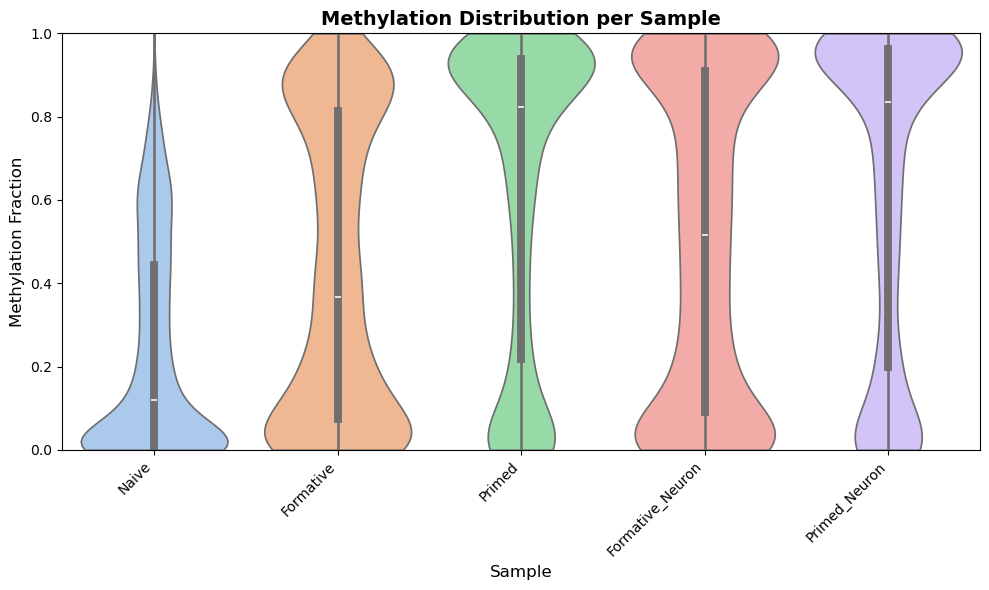

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

#ensure meth frac distribution is what i expect

# === Load data ===
df = pd.read_csv("cpgs_with_ME_ID.tsv", sep="\t")

# === Select methylation fraction columns ===
frac_cols = [col for col in df.columns if col.endswith('_frac')]

# === Melt dataframe to long format ===
df_long = df.melt(
    value_vars=frac_cols,
    var_name='Sample',
    value_name='Methylation'
)

# Drop missing values
df_long = df_long.dropna(subset=['Methylation'])

# Clean sample names (optional: remove "_frac" suffix)
df_long['Sample'] = df_long['Sample'].str.replace('_frac', '', regex=False)

# === Plot ===
plt.figure(figsize=(10, 6))
sns.violinplot(data=df_long, x='Sample', y='Methylation', palette='pastel', cut=0, inner='box')

plt.title('Methylation Distribution per Sample', fontsize=14, weight='bold')
plt.xlabel('Sample', fontsize=12)
plt.ylabel('Methylation Fraction', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.tight_layout()

# === Save ===
plt.savefig("methylation_violinplot_mes_kessler.pdf", format='pdf', bbox_inches='tight')
plt.savefig("methylation_violinplot_mes_kessler.svg", format='svg', bbox_inches='tight')
plt.show()